# Image classification: French cheeses

## Import TensorFlow and other libraries

In [ ]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
# import os
import pathlib
import pickle
# import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Import dataset

In this notebook we use the dataset ```auto_dataset_cleaned```, which uses a script to automatically download images from the internet, that are then checked manually.


In [ ]:
# Retrieve dataset
dataset_url = "https://github.com/seub/Cheezam/raw/main/data/cheese_photos_easy.tar.gz"
data_dir = tf.keras.utils.get_file('cheese_photos_easy', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(f'The data_dir is: {data_dir}')
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg')))
print(f'Found {image_count} jpg and jpeg images.')

## Create a tf.keras dataset

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")

## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(0.1, fill_mode='constant', input_shape=input_shape),
    layers.RandomZoom(0.1, fill_mode='constant'),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant')
    #layers.RandomFlip("horizontal")
  ])

## Visualize data sample

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    img_aug = data_augmentation(np.expand_dims(img, axis=0))[0]
    plt.imshow(img_aug.numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Import MobileV2 model from Keras

In [ ]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
#print(model_dictionary.keys())
model_func = model_dictionary['MobileNetV2']
base_model = model_func(include_top=False, pooling='avg', input_shape=input_shape, weights = 'imagenet')
base_model.trainable = False
print(f"Pre-trained MobileV2 model imported from Keras.")
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes))
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print(f"Added two dense layers to model.")
model.summary()

In [54]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        self.time_begin = time.perf_counter()
    def on_epoch_end(self,epoch,logs = {}):
        self.time_end = time.perf_counter()
        self.times.append(self.time_end - self.time_begin)
        self.time_begin = self.time_end
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Time')
        xticks = range(1, 1+len(self.times))
        plt.xticks(xticks)
        plt.plot(xticks, self.times)
        plt.ylim(bottom=0)
        plt.savefig('epochs_time.png')
        plt.show()

In [ ]:
def update_history(reset, history, model_path, epochs):
  model_path.mkdir(parents=False, exist_ok=True)
  history_path = model_path / 'training_history'
  if reset or (not history_path.is_file()):
    training_history = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[], 'epochs':0}
  else:
    training_history = pickle.load(open(history_path, 'rb'))
  training_history['acc'] += history.history['accuracy']
  training_history['val_acc'] += history.history['val_accuracy']
  training_history['loss'] += history.history['loss']
  training_history['val_loss'] += history.history['val_loss']
  training_history['epochs'] += epochs
  with open(history_path, 'wb') as file_pi:
    pickle.dump(training_history, file_pi)
  return training_history

In [ ]:
epochs = 1
model_path = pathlib.Path.home() / '.keras/models/MobileV2'
reset = True
if reset==False:
  assert model_path.is_dir()

timetaken = timecallback()
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[timetaken])
training_history = update_history(reset=reset, history=history, model_path=model_path, epochs=epochs)

Epoch 1/3
5/5 [==============================] - 3s 633ms/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 1.3759 - val_accuracy: 0.6237
Epoch 2/3
5/5 [==============================] - 3s 691ms/step - loss: 0.0469 - accuracy: 1.0000 - val_loss: 1.4061 - val_accuracy: 0.6075
Epoch 3/3
5/5 [==============================] - 3s 702ms/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 1.2970 - val_accuracy: 0.6398


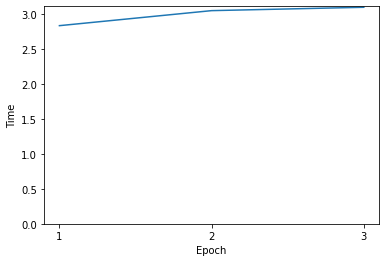

In [55]:
import time
epochs = 3
reset = False
if reset==False:
  assert model_path.is_dir()

timetaken = timecallback()
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[timetaken], steps_per_epoch=5)
training_history = update_history(reset=reset, history=history, model_path=model_path, epochs=epochs)

## Visualize training results

In [ ]:
def visualize_training(training_history):
    epochs_range = range(1, 1+training_history['epochs'])

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_history['acc'], label='Training Accuracy')
    plt.plot(epochs_range, training_history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_history['loss'], label='Training Loss')
    plt.plot(epochs_range, training_history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('output/training_history.png')
    plt.show()
visualize_training(training_history)

## Predict on new data

In [ ]:
from IPython.display import display

def cheezam(filepath : str):
    img = tf.keras.utils.load_img(filepath, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    display( PIL.Image.open(filepath).resize((img_height, img_width)) )

    print(
    "This cheese is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

    

In [ ]:
import random
import PIL
test_dir = pathlib.Path('data/sample_dataset')
test_paths_total = list(test_dir.glob('*/*.jpg'))
nb_test, nb_test_total = 10, len(test_paths_total)
test_paths = random.sample(test_paths_total, nb_test)
print(len(test_paths))
for test_path in test_paths:
    cheezam(test_path)